### Importing all libraries

In [1]:
#Importing audio file paths
import os

#For managing dataframe
import pandas as pd
import numpy as np

#PyTorch
import torchaudio
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from torch import nn

#Metrics
import seaborn as sb
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import ConfusionMatrix

# Misc.
import warnings
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm_notebook

warnings.filterwarnings("ignore")

#Selecting device
device="cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device}")

Using cuda


### Recursively get all audio files

In [2]:
def audio_fetch(src,audio_paths):
    l=os.listdir(src)
    if(len(l)!=0):
        for i in range(len(l)):
            if(".wav" in l[i] or ".mp3" in l[i] or ".aac" in l[i]):
                audio_paths.append(str(src+l[i]))
            elif("." not in l[i]):
                try:
                    audio_fetch(str(src+"/"+l[i]+"/"),audio_paths)
                except:
                    continue
                            
# For getting all possible classes along with their label encoding as a dictionary
def class_fetch(df: pd.DataFrame())->(list,dict):
    s=sorted(df[1].unique())
    
    toDel=[i for i in dict(df[1].value_counts(sort=True)).keys() if dict(df[1].value_counts(sort=True))[i]<3]
    for i in toDel:
        s.remove(i)
    d={}
    
    toDel_ids=[]
    for i in toDel:
        toDel_ids.extend(list(df[df[1]==i][0].values))
    
    
    count=0
    for i in s:
        d[i]=count
        count+=1
    return list(s),d, toDel_ids

### Dataset Class

In [3]:
def extract_process(data, sample_rate):
    output_result = np.array([])

    mean_zero = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    output_result = np.hstack((output_result, mean_zero))

    
    stft_out = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft_out, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, chroma_stft))

    mfcc_out = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    output_result = np.hstack((output_result, mfcc_out))

    root_mean_out = np.mean(librosa.feature.rms(y=data).T, axis=0)
    output_result = np.hstack((output_result, root_mean_out))

    mel_spectogram = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, mel_spectogram))
    

    return output_result

class audio_dataset(Dataset):
    def __init__(self,
                 info: str,
                 audio_path=None,
                 audio_files=None,
                 header=None) -> None:
        
        self.paths=[]

        if (audio_path==None and audio_files==None):
            raise Exception("Both audio_path and audio_files cannot be None at the same time")

        if(audio_files==None):
            audio_fetch(audio_path,self.paths)
        else:
            self.paths=audio_files
        
        self.patient=dict()
        self.paths.sort() 
        
        # We are going to remove all classes than 2 patient data

        for i in self.paths:
            index=int(i.split("/")[-1].split("_")[0])
            self.patient[index]=[]
        
        for i in range(len(self.paths)):
            self.patient[int(self.paths[i].split("/")[-1].split("_")[0])].append(self.paths[i])
        
        self.info_df=pd.read_csv(info,header=header)
        self.classes, self.class_to_idx, self.ids_to_remove = class_fetch(self.info_df)

        # After getting the patient ids to remove all the data from patient list is removed
        for i in self.ids_to_remove:
            if i in self.patient.keys():
                self.patient.pop(i)

        #Denotes sequence of audio files for a particular patient
        self.sequence=list(self.patient.values())

        # Audio path is updated after removing classing with small number of patients
        self.paths=[]
        for i in self.sequence:
            if(i!=[]):
                for j in i:
                    self.paths.append(j)

        self.scaler=StandardScaler()

    
    def get_class(self,file: str):
        return self.info_df[self.info_df[0]==int(file.split("/")[-1].split("_")[0])][1].values[0]
    
    def __len__(self) -> int:
        return len(self.paths)


    def __getitem__(self, index: int) -> torch.Tensor():
        self.val=self.paths[index]
        self.class_val=self.class_to_idx[self.get_class(self.val)]

        self.signal, self.sr = librosa.load(self.val)
        self.signal = torch.unsqueeze(torch.from_numpy(np.squeeze(self.scaler.fit_transform(np.reshape(extract_process(self.signal, self.sr),newshape=(-1,1))))),dim=0).type(torch.float32)

        return self.signal,self.class_val

##### Testing audio dataset

In [4]:
ds=audio_dataset(audio_path="../Sound_Classification/archive/Respiratory_Sound_Database/",info="../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv")
ds.class_to_idx

{'Bronchiectasis': 0,
 'Bronchiolitis': 1,
 'COPD': 2,
 'Healthy': 3,
 'Pneumonia': 4,
 'URTI': 5}

In [5]:
print(len(ds.sequence))
print(ds.get_class(ds.paths[3]))

123
COPD


### Dataloader

In [6]:
BATCH_SIZE=32

ds=[]
audio_fetch("../Sound_Classification/archive/respiratory_sound_database/",ds)

# Perform train test split
train_ds,temp_ds=train_test_split(ds,test_size=0.4)
test_ds,val_ds=train_test_split(temp_ds,test_size=0.5)

print(f"Before trimming:")
print(f"No. of audio files in train_ds: {len(train_ds)}\nNo. of audio files in test_ds: {len(test_ds)}\nNo. of audio files in val_ds: {len(val_ds)}")

train_ds=audio_dataset(audio_files=train_ds,info="../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv")
test_ds=audio_dataset(audio_files=test_ds,info="../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv")
val_ds=audio_dataset(audio_files=val_ds,info="../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv")

print(f"\nAfter trimming:")
print(f"No. of audio files in train_ds: {train_ds.__len__()}\nNo. of audio files in test_ds: {test_ds.__len__()}\nNo. of audio files in val_ds: {val_ds.__len__()}")

train_loader=torch.utils.data.DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=True)
val_loader=torch.utils.data.DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=True)

Before trimming:
No. of audio files in train_ds: 552
No. of audio files in test_ds: 184
No. of audio files in val_ds: 184

After trimming:
No. of audio files in train_ds: 552
No. of audio files in test_ds: 182
No. of audio files in val_ds: 183


##### Checking dataloader

In [7]:
im=next(iter(train_loader))[0]
im.shape

torch.Size([32, 1, 182])

In [8]:
im[0].dtype

torch.float32

### Setting up Tensorboard and performance metrics

In [9]:
log_dir = "../"+"performance"
writer = SummaryWriter(log_dir=log_dir)

def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)

f1_fn=MulticlassF1Score(num_classes=len(train_ds.classes)).to(device)
cf_matrix=ConfusionMatrix(num_classes=len(train_ds.classes),task="multiclass")

### Model 1 (Simple Conv1D Network)

In [10]:
class auditory_transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_embedding=nn.Sequential(nn.Conv1d(in_channels=1,out_channels=256,stride=1,kernel_size=5),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=2,padding=1),
                                           nn.Conv1d(in_channels=256,out_channels=256,kernel_size=4),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=1,padding=1),
                                           nn.Conv1d(in_channels=256,out_channels=128,kernel_size=4),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=2,padding=1),
                                           nn.Conv1d(in_channels=128,out_channels=64,kernel_size=4),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=2,padding=1),
                                           nn.Conv1d(in_channels=64,out_channels=32,kernel_size=5),
                                           nn.ReLU(),
                                           nn.MaxPool1d(kernel_size=5,stride=2,padding=1),
                                           nn.Dropout(p=0.2),
                                           nn.Flatten(),
                                           nn.ReLU(),
                                           nn.Linear(in_features=192,out_features=32,bias=True),
                                           nn.ReLU(),
                                           nn.Dropout(p=0.3),
                                           nn.Linear(in_features=32,out_features=len(train_ds.classes),bias=True))

    def forward(self,x):
        return self.input_embedding(x)

#### Model 1 testing and training

In [11]:
next(iter(train_loader))[0].shape

torch.Size([32, 1, 182])

In [12]:
model=auditory_transformer().to(device)
with torch.inference_mode():
    print(model((next(iter(train_loader))[0]).to(device)).shape)

torch.Size([32, 6])


##### Optimizer and loss function

In [13]:
optimizer=torch.optim.Adam(params=model.parameters())
loss_fn=nn.CrossEntropyLoss()

##### Training Function

In [14]:
def train_model(model,epochs):
    for i in tqdm_notebook(range(epochs)):
        train_preds=torch.tensor([])
        test_preds=torch.tensor([])
        train_actual=torch.tensor([])
        test_actual=torch.tensor([])
        
        print("\nTraining:")
        model.train()
        
        #Defining accuracy and loss for train and test data
        temp_train_accuracy=[]
        temp_test_accuracy=[]
        temp_train_loss=[]
        temp_test_loss=[]
        temp_train_f1=[]
        temp_test_f1=[]
    
        net_train_accuracy=0
        net_test_accuracy=0
        net_train_loss=0
        net_test_loss=0
        net_train_f1=0
        net_test_f1=0
        
        with tqdm_notebook(total=len(train_loader)) as pbar:
            for x,y in train_loader:
                    x=x.to(device)
                    y=y.to(device)
        
                    #Calculating model output
                    logits=model(x)
        
                    #Reseting any old gradient values
                    optimizer.zero_grad()
                    loss=loss_fn(logits.squeeze(),y)
                
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    train_preds=torch.hstack((train_preds,preds.to("cpu")))
                    train_actual=torch.hstack((train_actual,y.to("cpu")))
                    accuracy_train=accuracy_fn(logits.type(torch.float32),y)
                    f1_train=f1_fn(preds,y)
                    temp_train_accuracy.append(accuracy_train)
                    temp_train_loss.append(loss.item())
                    temp_train_f1.append(f1_train.item())
                
                    #Back Propogation
                    loss.backward()
                
                    #Update Parameters
                    optimizer.step()
                
                    #Progress Bar Update
                    pbar.update(1)
            pbar.close()
        #Tensorboard & Metrics for the dataset
        net_train_accuracy=sum(temp_train_accuracy)/len(temp_train_accuracy)
        net_train_loss=sum(temp_train_loss)/len(temp_train_loss)
        net_train_f1=sum(temp_train_f1)/len(temp_train_f1)
        writer.add_scalar("Train Accuracy",net_train_accuracy,i)
        writer.add_scalar("Train Loss",net_train_loss,i)
        writer.add_scalar("Train F1 Score",net_train_f1)
    
        #Evaluation
        print("Testing:")
        model.eval()
    
        with tqdm_notebook(total=len(test_loader)) as pbar2:
            for x,y in test_loader:
                x=x.to(device)
                y=y.to(device)
                
                #Setting inference mode
                with torch.inference_mode():
                    logits=model(x)
                    loss=loss_fn(logits.squeeze().type(torch.float32),y)
    
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    test_preds=torch.hstack((test_preds,preds.to("cpu")))
                    test_actual=torch.hstack((test_actual,y.to("cpu")))
                    accuracy_test=accuracy_fn(logits,y)
                    f1_test=f1_fn(preds,y)
                    temp_test_accuracy.append(accuracy_test)
                    temp_test_loss.append(loss.item())
                    temp_test_f1.append(f1_test.item())
    
                    #Progress Bar Update
                    pbar2.update(1)
            pbar2.close()
    
        #Tensorboard & Metrics for the dataset
        net_test_accuracy=sum(temp_test_accuracy)/len(temp_test_accuracy)
        net_test_loss=sum(temp_test_loss)/len(temp_test_loss)
        net_test_f1=sum(temp_test_f1)/len(temp_test_f1)
        writer.add_scalar("Test Accuracy",net_test_accuracy,i)
        writer.add_scalar("Test Loss",net_test_loss,i)
        writer.add_scalar("Test F1 Score",net_test_f1,i)

        '''
        #Saving the model
        try:
            os.makedirs(f"./{model_name}_feature_extractor/")
        except Exception as e:
            pass
        torch.save(model.state_dict(),f"./{model_name}_feature_extractor/checkpoint-{i+1}.pth")
        '''
        
        print(f"\nEpoch {i+1}:\n\nTrain Accuracy: {net_train_accuracy}\n\nTrain Loss: {net_train_loss}\n\nTrain F1 Score: {net_train_f1}\n\nTest Accuracy: {net_test_accuracy}\n\nTest Loss: {net_test_loss}\n\nTest F1 Score: {net_test_f1}")

        #Plotting confusion matrix
        print("\n")
        plt.figure(figsize=(10,5))
        sb.heatmap(cf_matrix(train_preds,train_actual),annot=True,xticklabels=train_ds.classes,yticklabels=train_ds.classes)
        plt.title("Train confusion matrix")
        plt.xlabel("Predictions")
        plt.ylabel("True")
        plt.show()
        
        print("\n")
        plt.figure(figsize=(10,5))
        sb.heatmap(cf_matrix(test_preds,test_actual),annot=True,xticklabels=train_ds.classes,yticklabels=train_ds.classes)
        plt.title("Test confusion matrix")
        plt.xlabel("Predictions")
        plt.ylabel("True")
        plt.show()

##### Training Model 1

  0%|          | 0/30 [00:00<?, ?it/s]


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 1:

Train Accuracy: 0.8038194444444444

Train Loss: 0.8621520946423212

Train F1 Score: 0.2343655087881618

Test Accuracy: 0.8991477272727272

Test Loss: 0.40358981241782504

Test F1 Score: 0.402351217965285




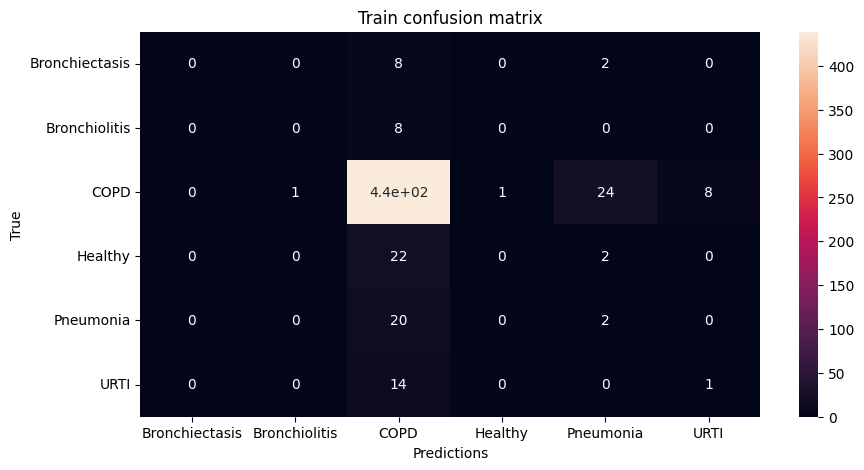

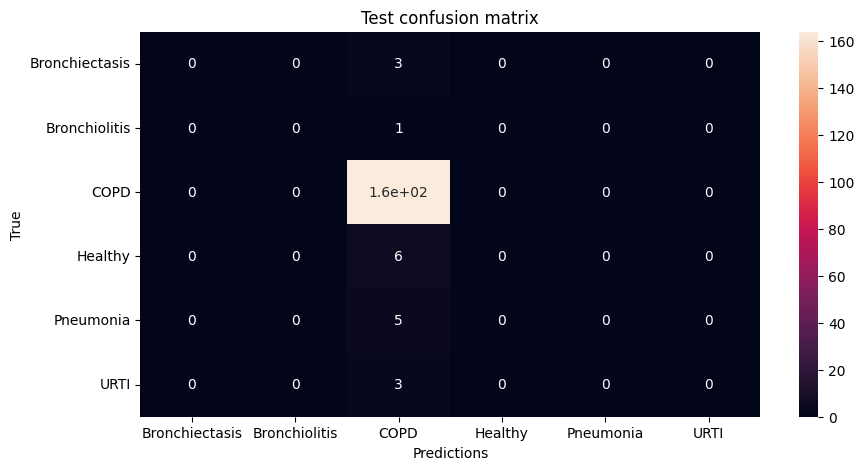


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 2:

Train Accuracy: 0.8524305555555556

Train Loss: 0.6092498650153478

Train F1 Score: 0.25395163231425816

Test Accuracy: 0.9015151515151515

Test Loss: 0.3791011869907379

Test F1 Score: 0.2634747177362442




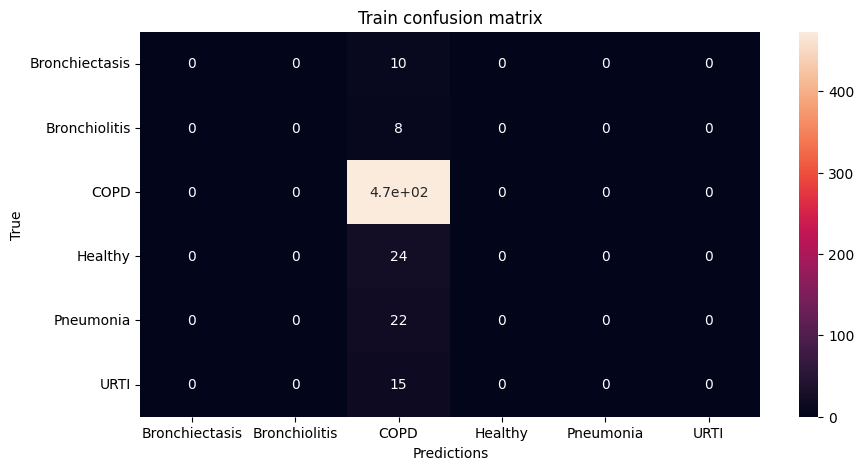

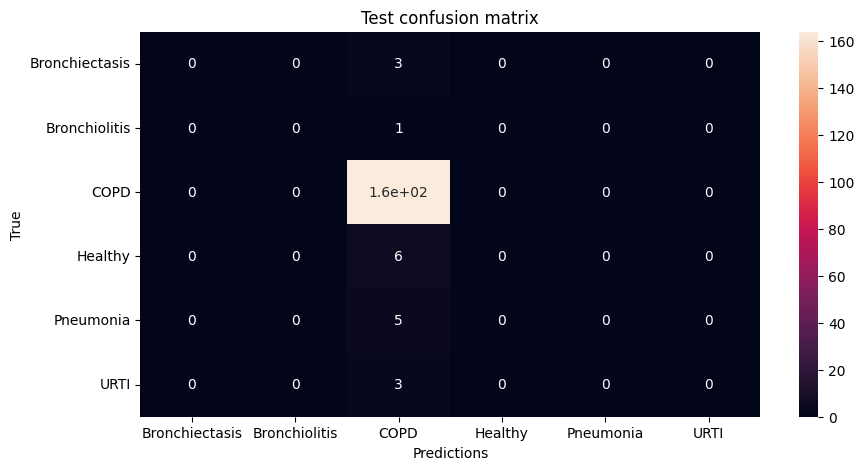


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 3:

Train Accuracy: 0.8576388888888888

Train Loss: 0.6012976103358798

Train F1 Score: 0.2699762276477284

Test Accuracy: 0.90625

Test Loss: 0.5244327783584595

Test F1 Score: 0.4034288351734479




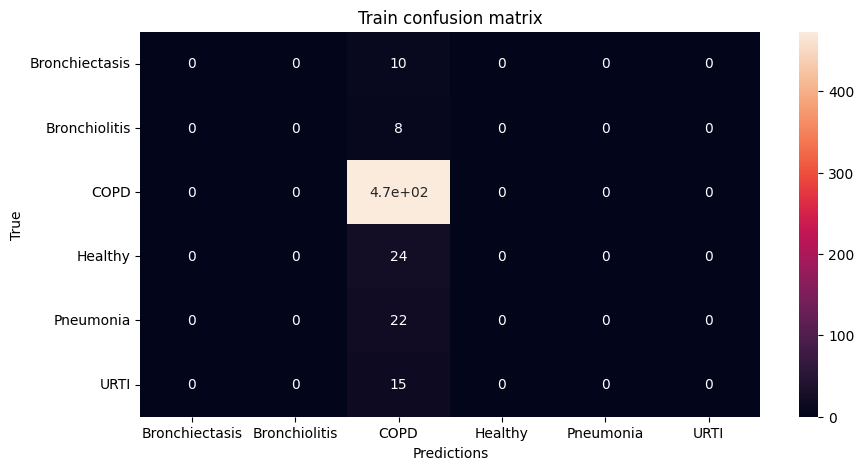

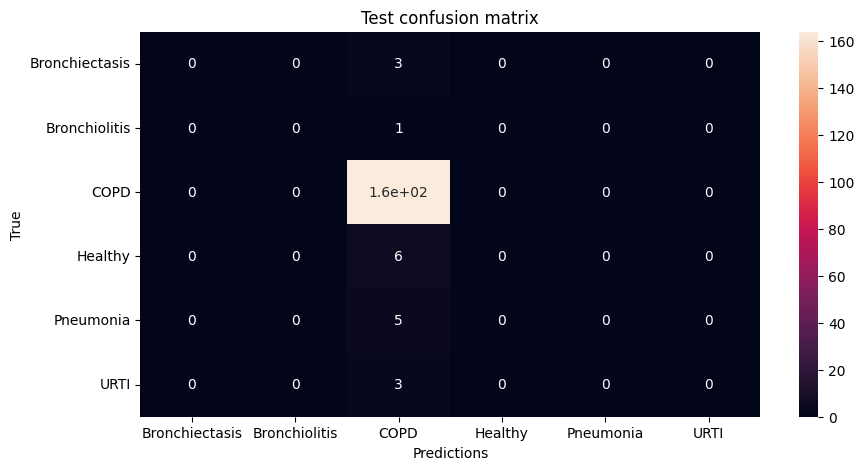


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 4:

Train Accuracy: 0.8576388888888888

Train Loss: 0.594893624385198

Train F1 Score: 0.26238002876440686

Test Accuracy: 0.8991477272727272

Test Loss: 0.36831216762463254

Test F1 Score: 0.30390650530656177




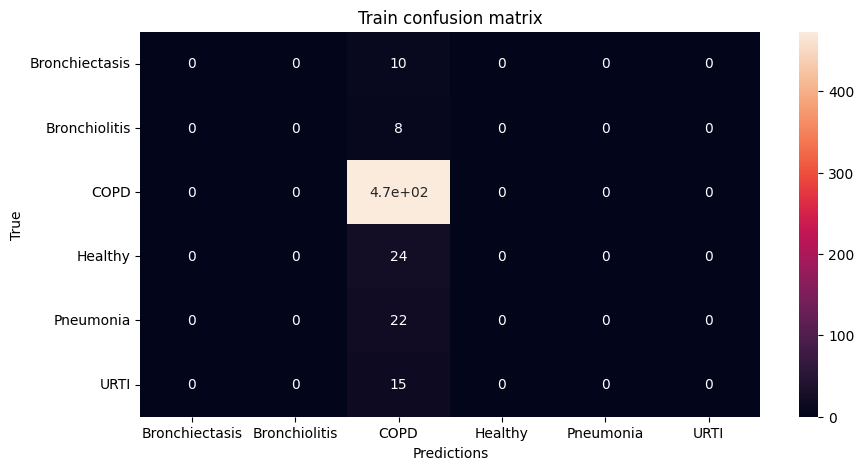

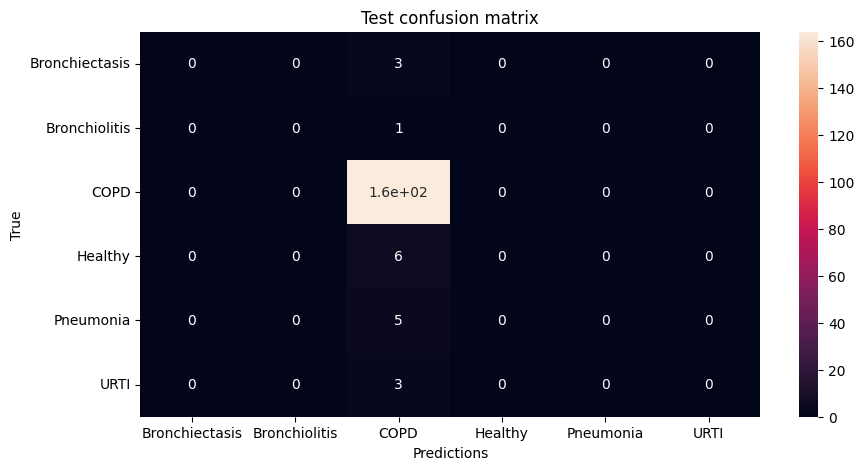


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 5:

Train Accuracy: 0.8576388888888888

Train Loss: 0.5553019262022443

Train F1 Score: 0.2624663362900416

Test Accuracy: 0.8944128787878788

Test Loss: 0.43600112696488696

Test F1 Score: 0.3707359830538432




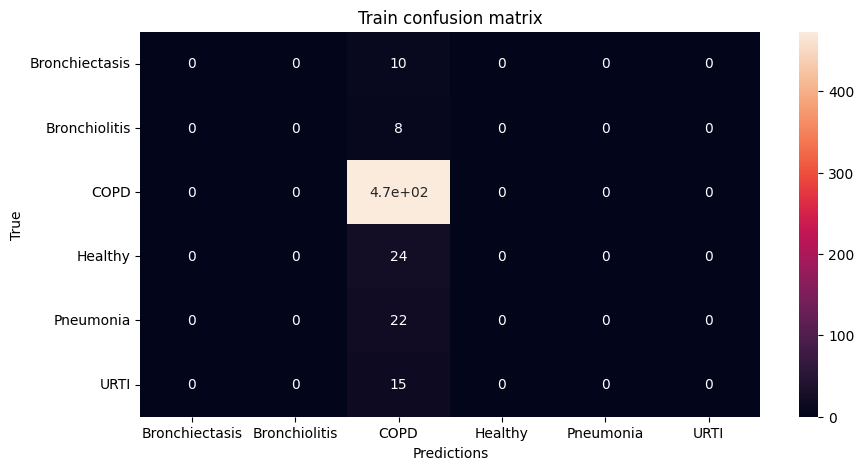

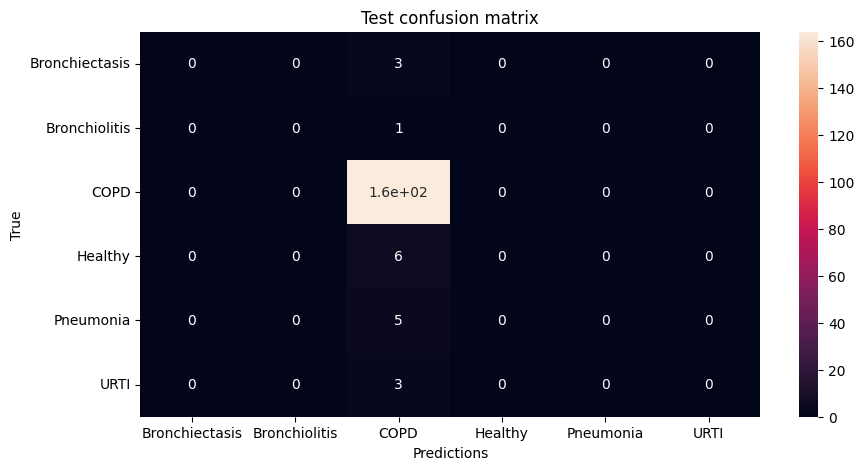


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 6:

Train Accuracy: 0.8628472222222222

Train Loss: 0.5564859575695462

Train F1 Score: 0.3251911343799697

Test Accuracy: 0.8967803030303031

Test Loss: 0.3859529495239258

Test F1 Score: 0.32912755260864895




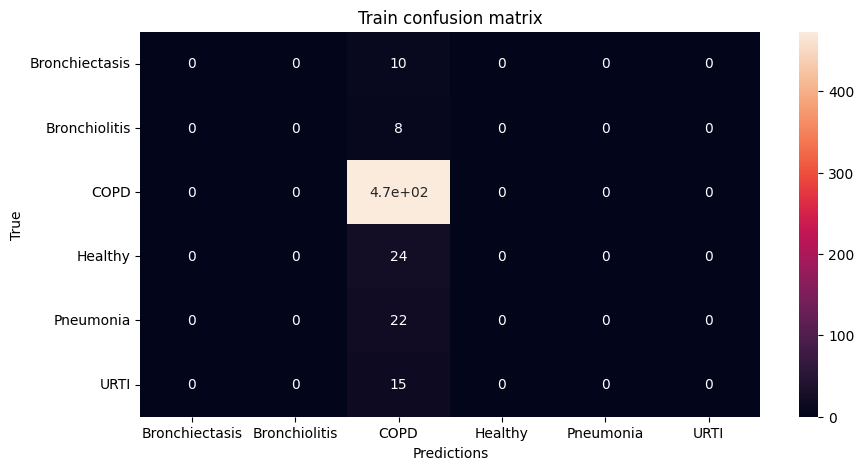

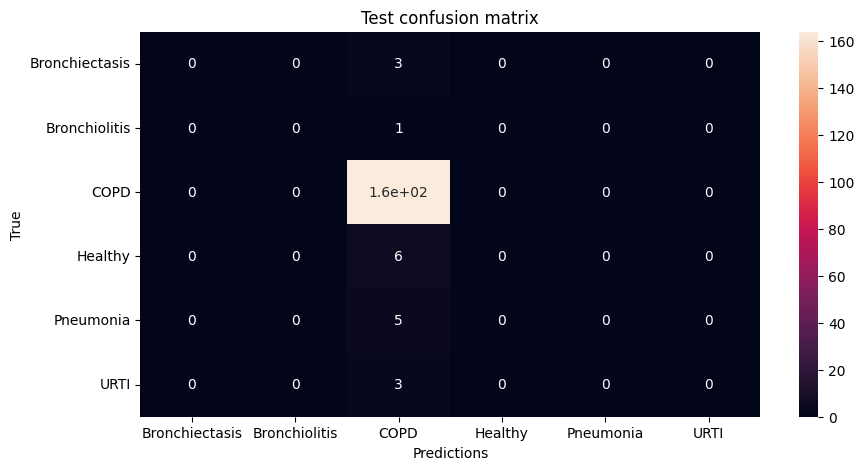


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 7:

Train Accuracy: 0.8576388888888888

Train Loss: 0.5735136013891962

Train F1 Score: 0.3135153626402219

Test Accuracy: 0.8991477272727272

Test Loss: 0.4419335027535756

Test F1 Score: 0.29603223502635956




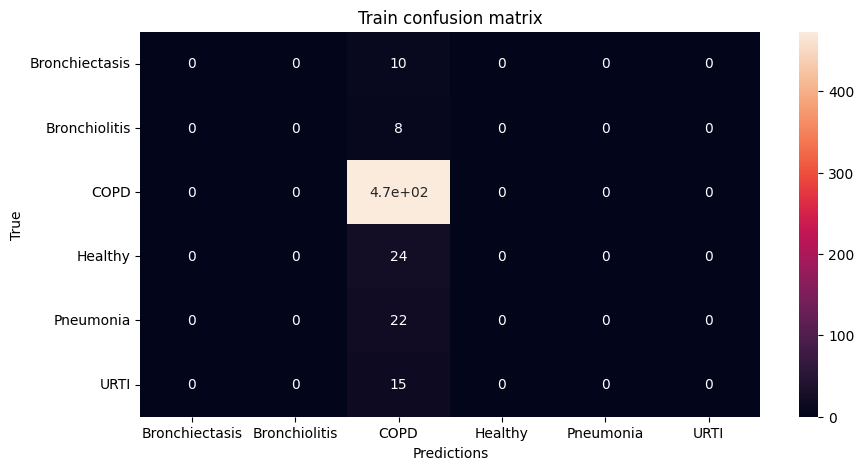

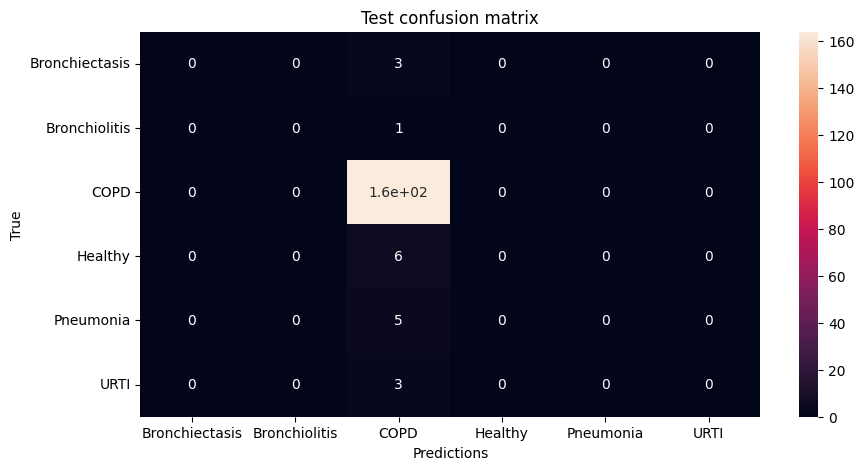


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 8:

Train Accuracy: 0.8524305555555556

Train Loss: 0.5880947709083557

Train F1 Score: 0.25935403257608414

Test Accuracy: 0.8991477272727272

Test Loss: 0.3956998959183693

Test F1 Score: 0.39393438895543414




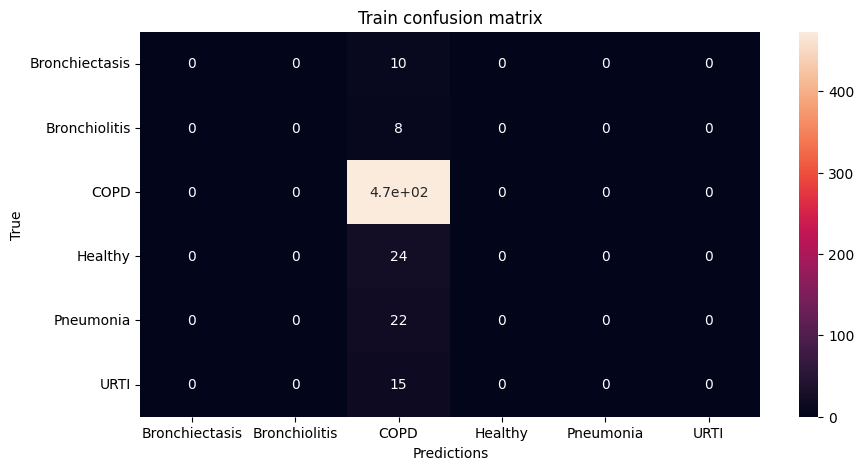

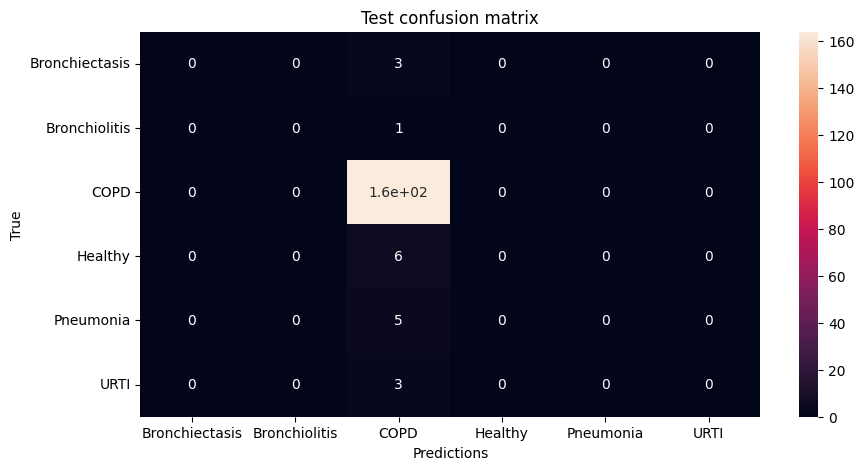


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 9:

Train Accuracy: 0.8576388888888888

Train Loss: 0.546070451537768

Train F1 Score: 0.26724476450019413

Test Accuracy: 0.9015151515151515

Test Loss: 0.3512825568517049

Test F1 Score: 0.3643910636504491




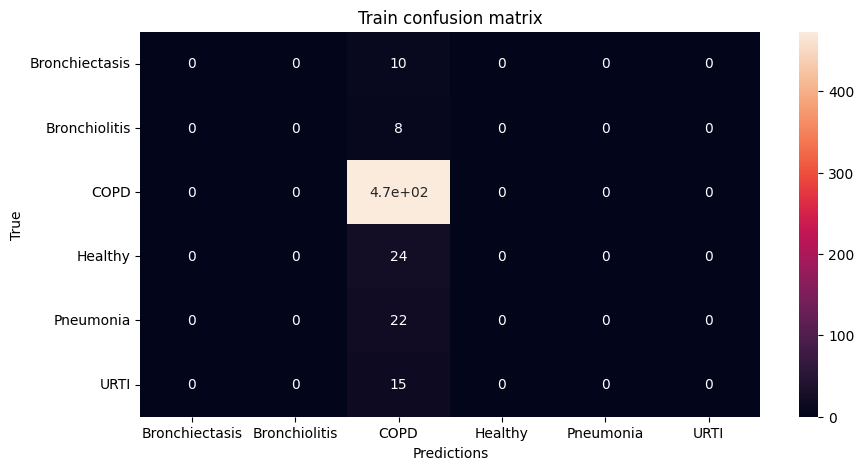

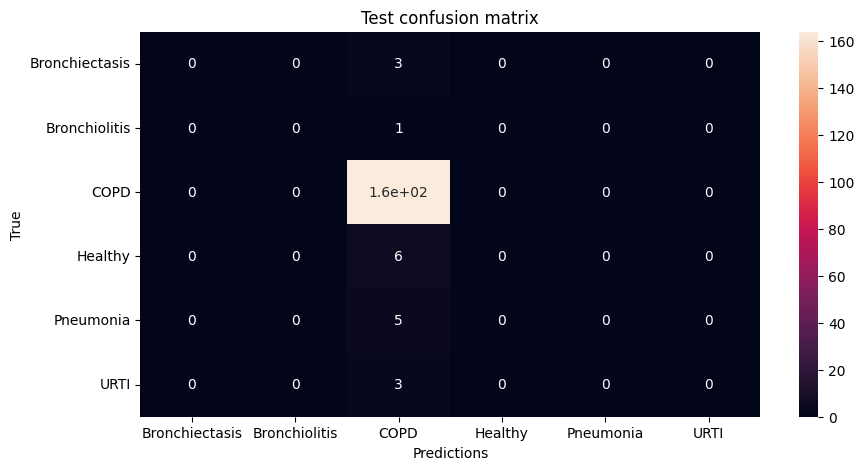


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 10:

Train Accuracy: 0.8524305555555556

Train Loss: 0.5768896987040838

Train F1 Score: 0.26753998216655517

Test Accuracy: 0.9015151515151515

Test Loss: 0.35147226601839066

Test F1 Score: 0.29651593665281933




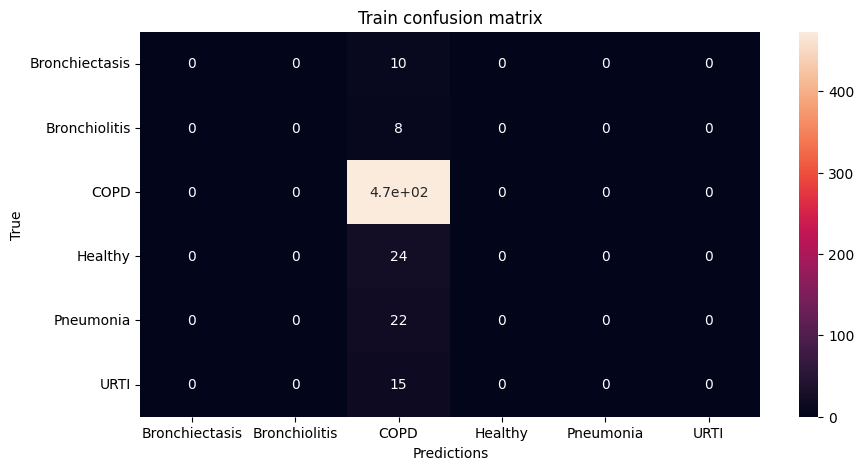

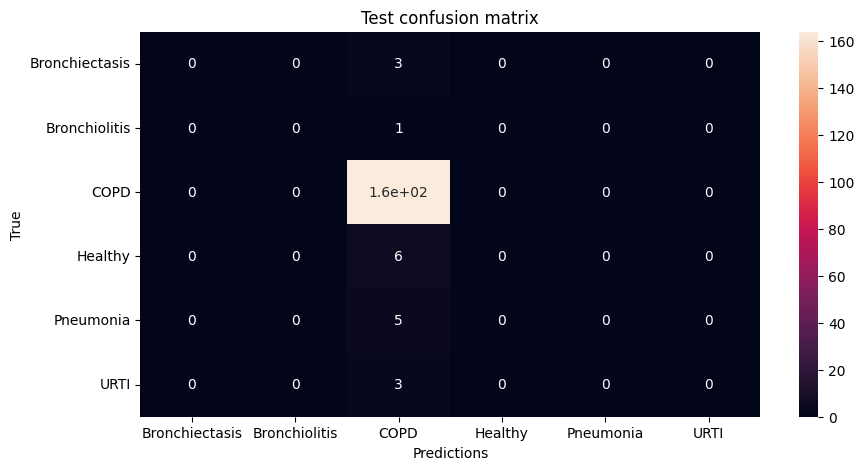


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 11:

Train Accuracy: 0.8576388888888888

Train Loss: 0.572398864560657

Train F1 Score: 0.2591873879233996

Test Accuracy: 0.8991477272727272

Test Loss: 0.3781469811995824

Test F1 Score: 0.29098320255676907




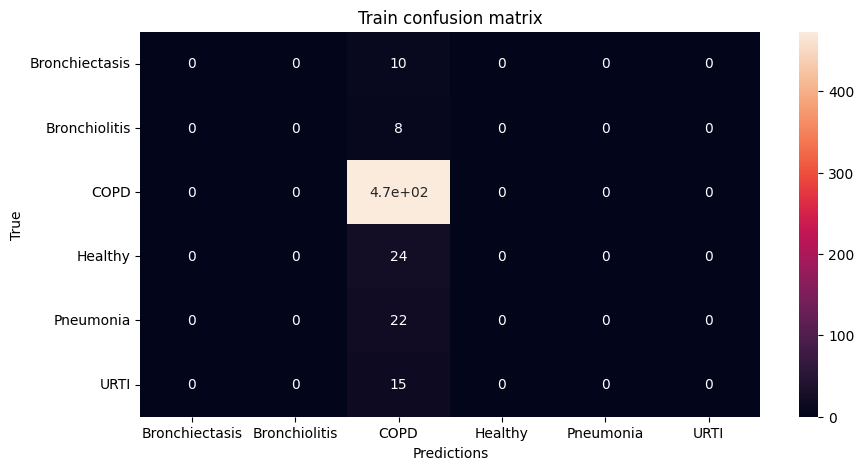

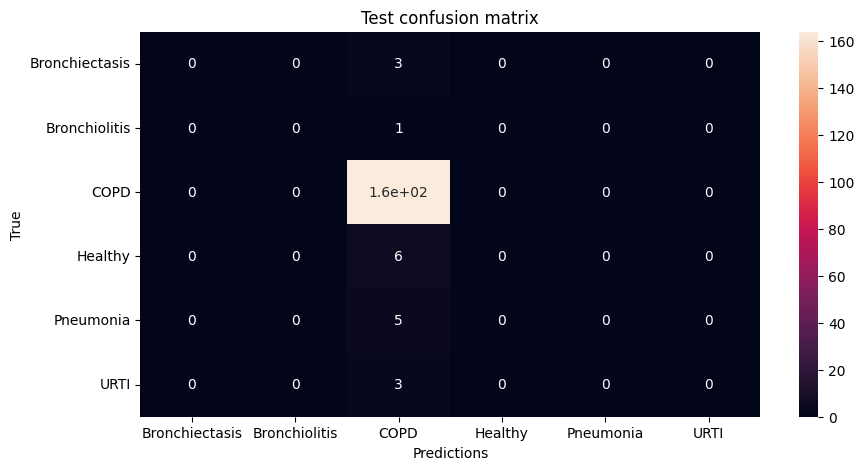


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 12:

Train Accuracy: 0.8524305555555556

Train Loss: 0.5721213047703108

Train F1 Score: 0.299682376285394

Test Accuracy: 0.90625

Test Loss: 0.3791544089714686

Test F1 Score: 0.40354572981595993




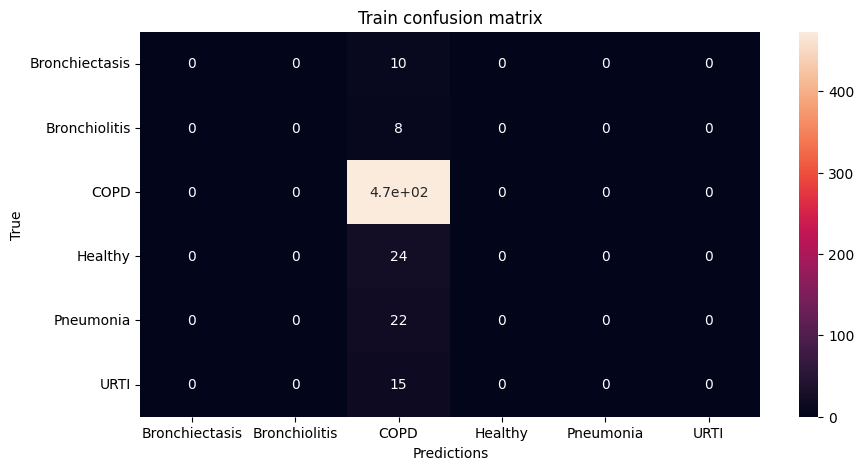

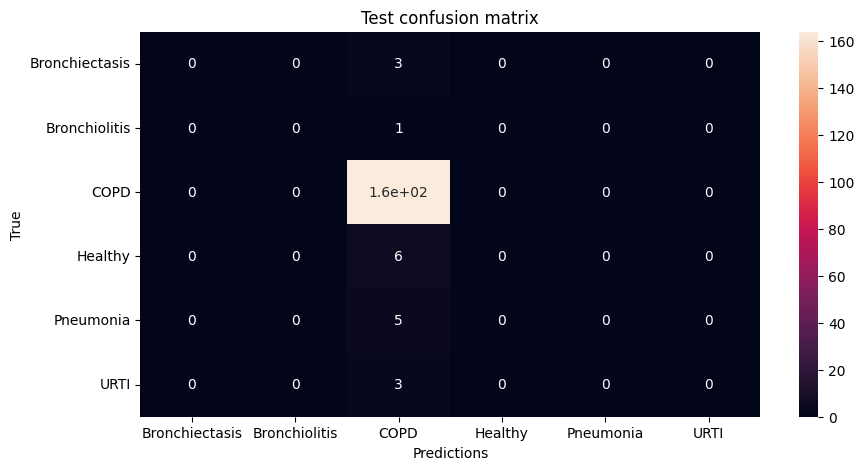


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 13:

Train Accuracy: 0.8628472222222222

Train Loss: 0.5636451294024786

Train F1 Score: 0.29358865569035214

Test Accuracy: 0.9015151515151515

Test Loss: 0.354793980717659

Test F1 Score: 0.26167400429646176




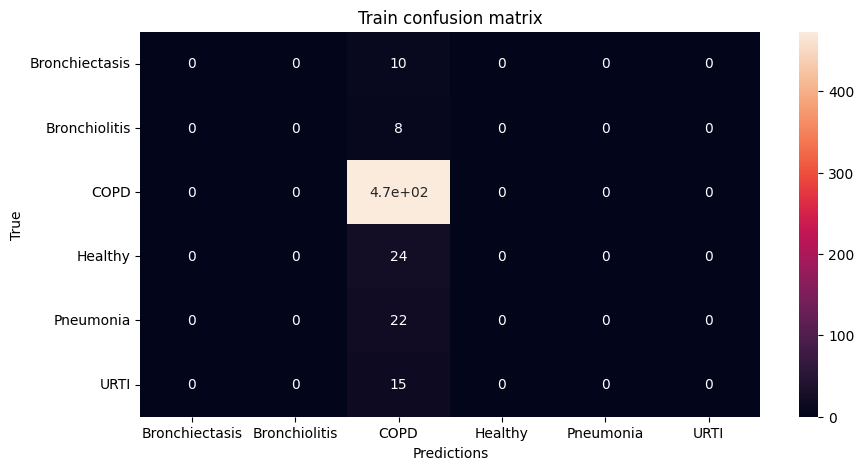

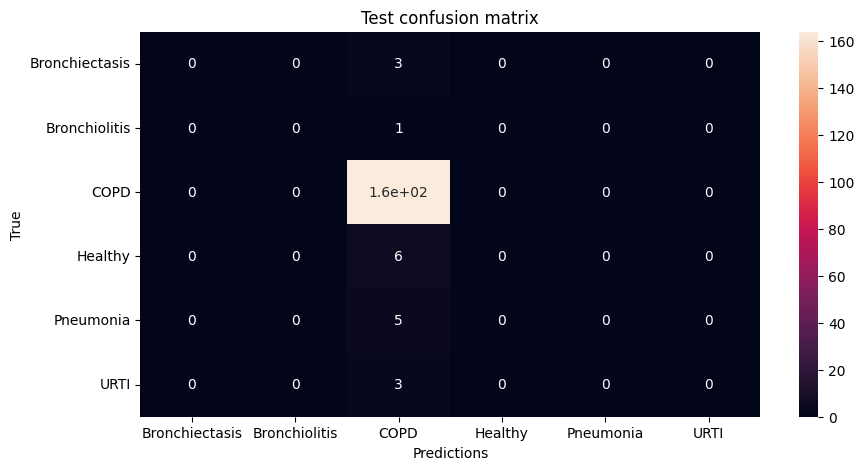


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 14:

Train Accuracy: 0.8472222222222222

Train Loss: 0.5773488680521647

Train F1 Score: 0.2594950422644615

Test Accuracy: 0.9015151515151515

Test Loss: 0.36864107847213745

Test F1 Score: 0.31759174913167953




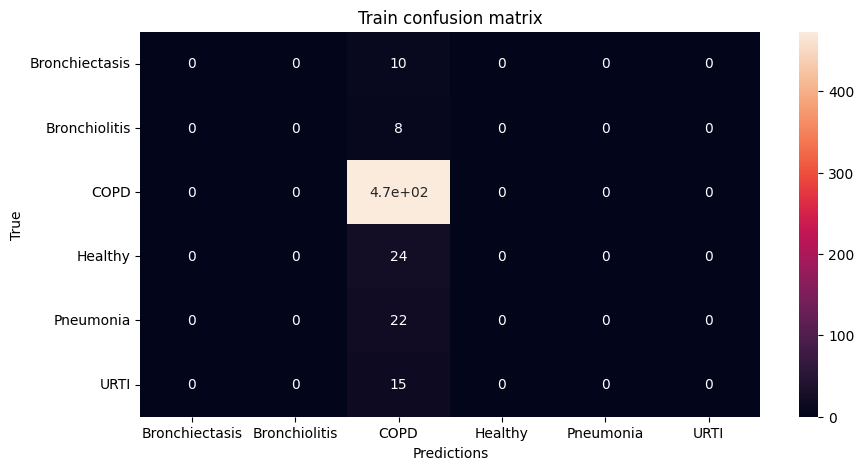

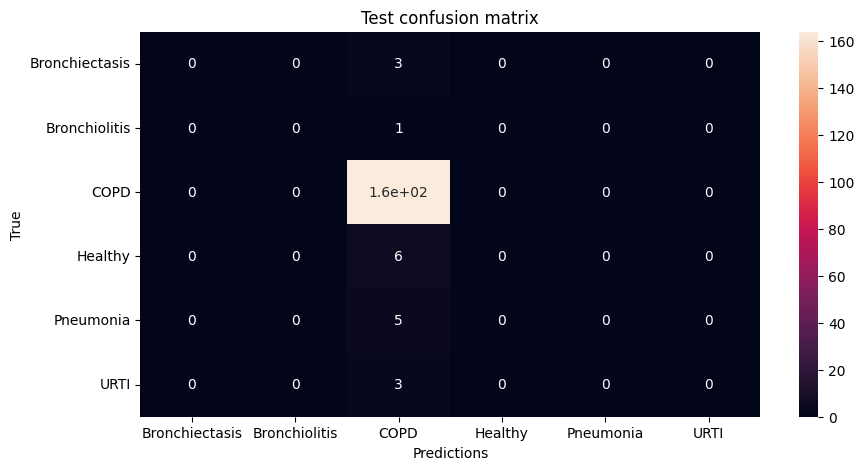


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 15:

Train Accuracy: 0.8524305555555556

Train Loss: 0.578557593954934

Train F1 Score: 0.26881785690784454

Test Accuracy: 0.9015151515151515

Test Loss: 0.36821245153745014

Test F1 Score: 0.31711577624082565




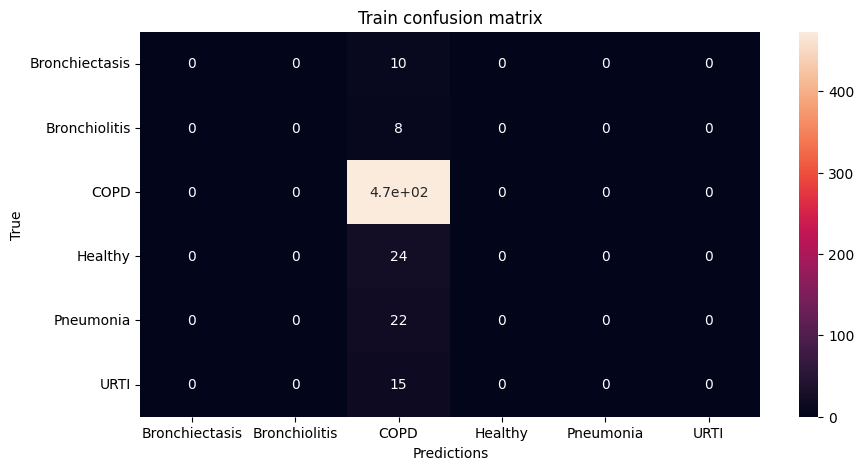

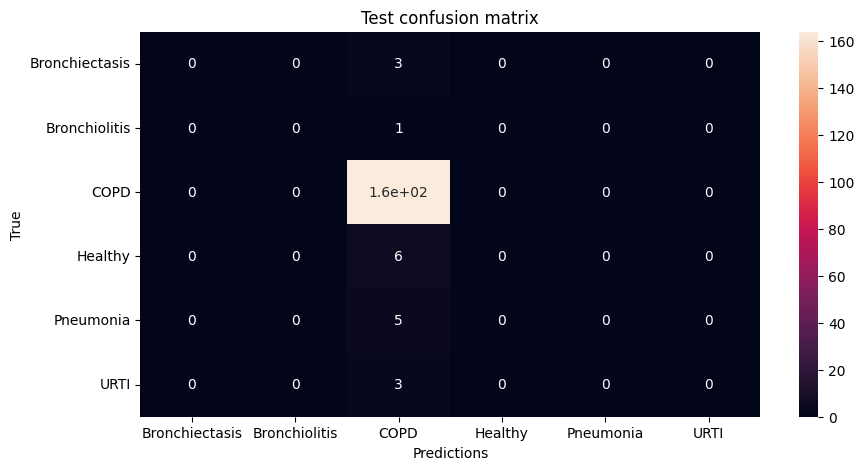


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 16:

Train Accuracy: 0.8628472222222222

Train Loss: 0.5201661032107141

Train F1 Score: 0.2694912801186244

Test Accuracy: 0.9038825757575758

Test Loss: 0.3466911440094312

Test F1 Score: 0.2913675680756569




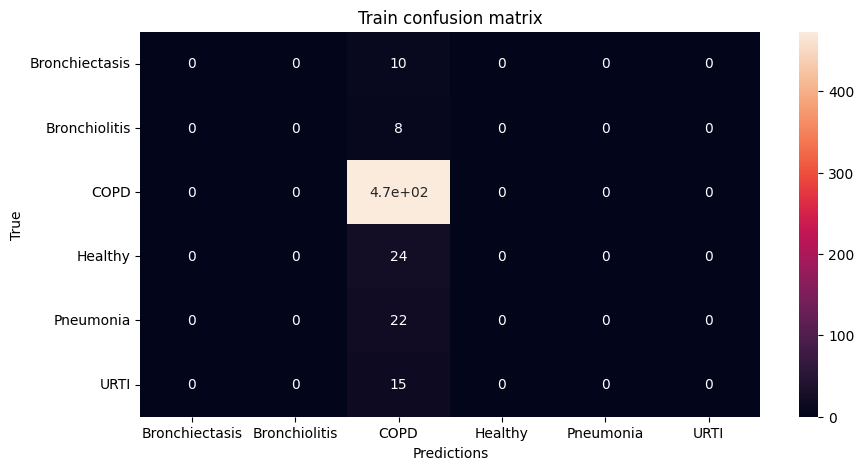

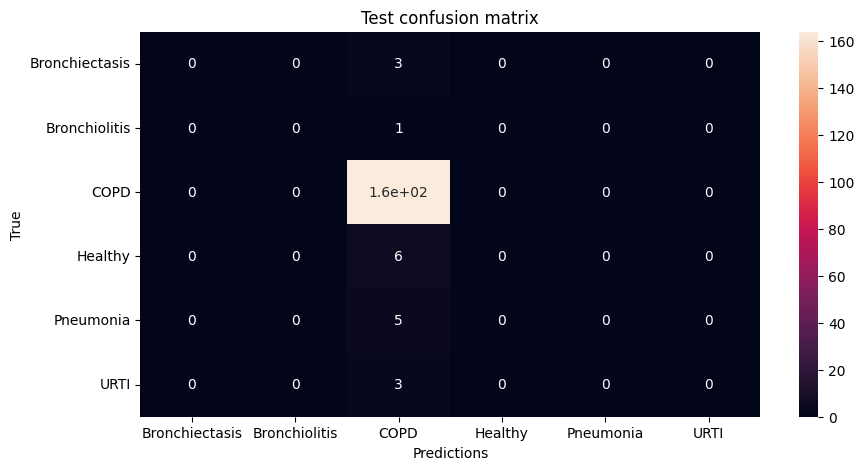


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 17:

Train Accuracy: 0.8628472222222222

Train Loss: 0.5304924175143242

Train F1 Score: 0.29276447577608955

Test Accuracy: 0.9015151515151515

Test Loss: 0.34185059865315753

Test F1 Score: 0.2828444391489029




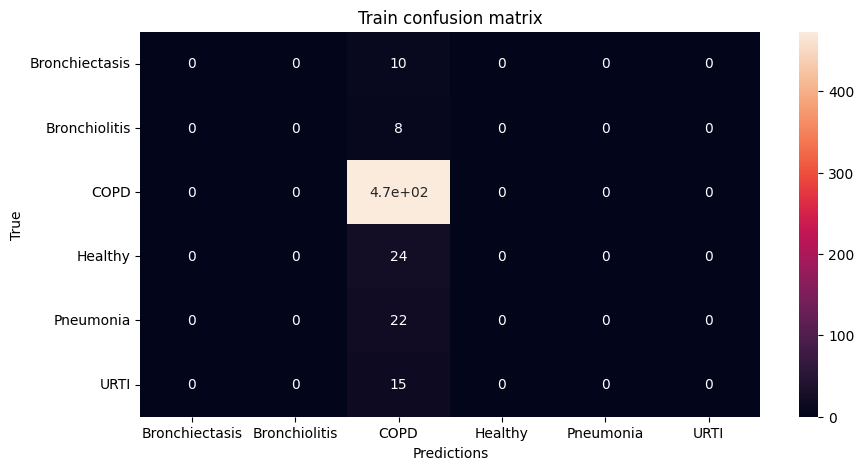

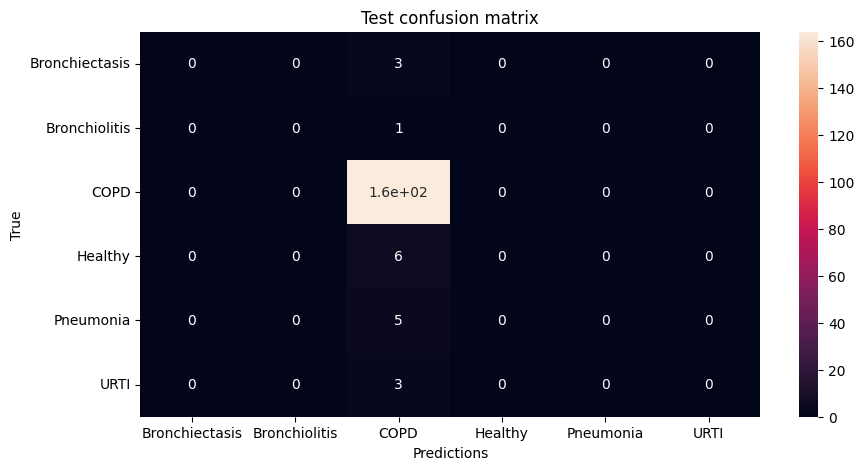


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

Testing:


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 18:

Train Accuracy: 0.8576388888888888

Train Loss: 0.5548391789197922

Train F1 Score: 0.297180649307039

Test Accuracy: 0.90625

Test Loss: 0.32719307268659276

Test F1 Score: 0.40229060997565586




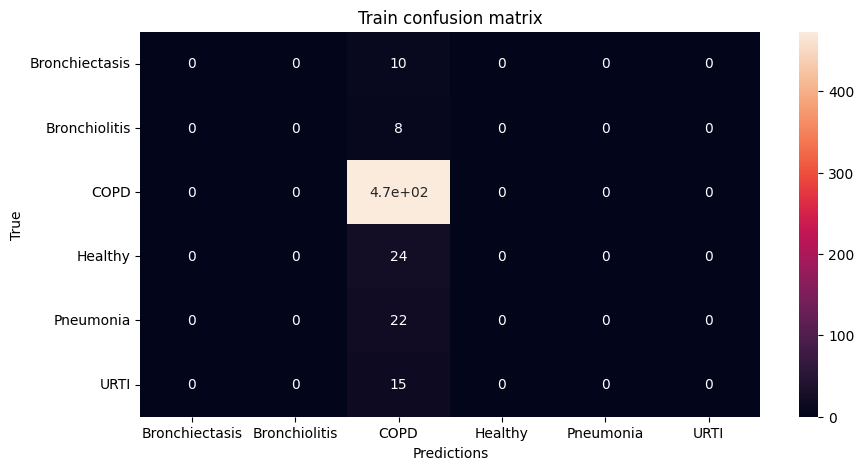

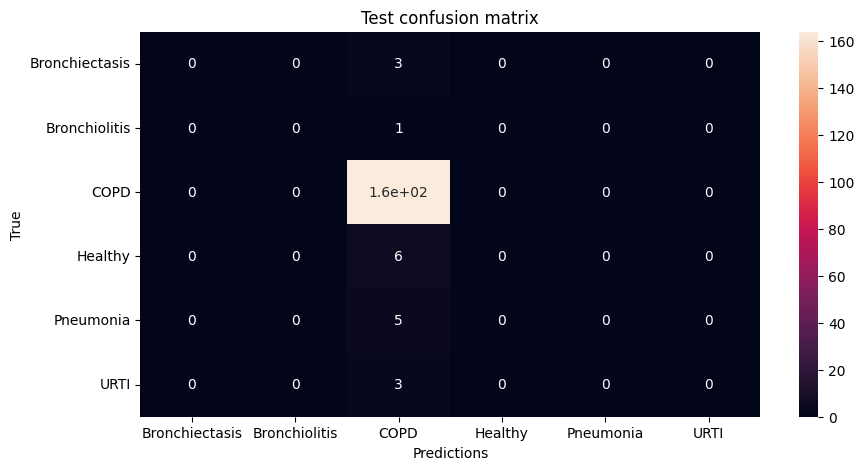


Training:


  0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
epochs=30
train_model(model,epochs)